# Note:
This version of the notebook using `softmax` activation for encoder output instead of `linear` + batch normalization.
It forces the autoencoder here to deliver sparse representation, and, induce more interesting dreams. The dreams are colorful and wild due to a *frozen distribution* (similar to mode collapse in GANs):
the agent "[developed qualia](https://en.wikipedia.org/wiki/Qualia)", *clear idea* of the noise.
([Compare with the original version.](Autoencoder.ipynb))

### Moving self around
The agent got some *senses*: [background](VAE.ipynb) and [dynamics](ConvLSTM.ipynb).
For the next challenge we want some *self-awareness*: this time we want the agent to develop some reasonable expectation of what it would see after taking a specific action in a specific state.

Note: we used term *self-awareness* here to refer the composite model which requires an internal representation build and maintained, vs. *senses* which refer here the simple direct-mapping models.

In [1]:
import gym
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from gym_unity.envs import UnityEnv
from local import train_online, plot_history, plot_predicted_vs_observed
from local import run_seq, encoding_heatmap
%matplotlib inline

Using TensorFlow backend.


In [2]:
env_name = None # use Unity editor with SimpleEnvironment scene active
#env_name = './Exec/Background' # use executable
env = UnityEnv(env_name, worker_id = 0, use_visual = True)

INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: SimpleEnvironment
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: Turn HORIZONTAL, Tilt VERTICAL
INFO:gym_unity:1 agents within environment.


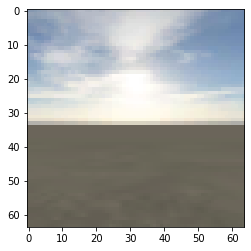

In [3]:
env.reset()
# get observation after taking action 0,0 (doing nothing)
observation, r, s, info = env.step([0.0, 0.0])

plt.imshow(observation)
plt.show()

In [4]:
IMG_DIM = observation.shape
ACT_DIM = (2,) # azimuth, altitude
N_CHANNELS = observation.shape[-1]
print('Image shape: {}  Flat size: {}  Channels: {}'\
      .format(IMG_DIM, np.prod(IMG_DIM), N_CHANNELS))

Image shape: (64, 64, 3)  Flat size: 12288  Channels: 3


## Autoencoder
For this exercise we are going to build a multi-layer convolutional neural network which predicts the next observation given the current observation and the action taken. We build a composite model: encoder, decoder, and mapper; and we train all three *online*.

In [5]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Dense, Flatten, Concatenate, Reshape
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU

In [6]:
# agent's brain capacity
LATENT_DIM = 8

# agent's moves
ACTION = {
    'Right':[1., 0.],
    'Left':[-1., 0.],
    'Up':[0., -1.],
    'Down':[0., 1.],
    'View':[0., 0.] }

In [7]:
# agent's cortex structure
N_FILTERS = 32
N_LAYERS = 3

In [8]:
# take an observation + action pair and output `idea`
def encoder(img_dim, act_dim, latent_dim, name = 'encoder'):
    n, f, s = N_LAYERS, N_FILTERS, (3, 3)
    observation = Input(shape = img_dim, name = 'observation')
    action = Input(shape = act_dim, name = 'action')
    thought = observation
    # hidden convolution layers
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        # normalization is important here
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = MaxPooling2D((2, 2), padding = 'same')(thought)
    thought = Flatten()(thought)
    thought = Concatenate()([thought, action])
    idea = Dense(latent_dim, activation = 'softmax', name = 'idea')(thought)
    return Model([observation, action], idea, name = name)

In [9]:
# instantiate encoder model
encode = encoder(IMG_DIM, ACT_DIM, LATENT_DIM)
encode.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         observation[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [10]:
# take `idea` and restore the image in the original format
def decoder(img_dim, latent_dim, name = 'decoder'):
    n, f, s = N_LAYERS - 1, N_FILTERS, (5, 5)
    d = img_dim[0]//np.power(2, n)
    idea = Input(shape = (latent_dim,), name = 'idea')
    thought = Dense(d * d * f, activation = 'relu')(idea)
    thought = Reshape((d, d, f))(thought)
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = UpSampling2D((2, 2))(thought)
    view = Conv2D(img_dim[-1], (3, 3), activation = 'sigmoid', padding = 'same', name = 'imagined')(thought)    
    return Model(idea, view, name = name)

In [11]:
# instantiate decoder model
decode = decoder(IMG_DIM, LATENT_DIM)
decode.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
idea (InputLayer)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              73728     
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
__________

In [12]:
# put it all together
def autoencoder(img_dim, act_dim, latent_dim):
    # encoder
    encode = encoder(img_dim, act_dim, latent_dim)
    encode.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # decoder
    decode = decoder(img_dim, latent_dim)
    decode.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # inputs
    observation = Input(shape = img_dim, name = 'observation')
    action = Input(shape = act_dim, name = 'action')
    # network
    mapper = Model([observation, action], decode(encode([observation, action])))
    mapper.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return encode, decode, mapper


encode, decode, model = autoencoder(IMG_DIM, ACT_DIM, LATENT_DIM)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
action (InputLayer)             (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            36184       observation[0][0]                
                                                                 action[0][0]                     
__________________________________________________________________________________________________
decoder (Model)                 (None, 64, 64, 3)    126115      encoder[1][0]                    
Total para

In [13]:
# return inputs, targets
def make_batch(V, A, X):
    # we've got V: observations resulted from actions A
    # we need observations A was initiated from
    # discard first pair and instead append pair:
    # zero-action (no move) and the last observation
    A1 = np.vstack((A[1:,:], np.zeros((1, 2))))
    V1 = np.vstack((V[1:,:], V[-1:,:]))
    return [V, A1], V1

      1 Loss  trainig: 0.0508 validation: 0.0687
     10 Loss  trainig: 0.0075 validation: 0.0192
     20 Loss  trainig: 0.0067 validation: 0.0096
     30 Loss  trainig: 0.0057 validation: 0.0078
     40 Loss  trainig: 0.0056 validation: 0.0065
     50 Loss  trainig: 0.0055 validation: 0.0067
     60 Loss  trainig: 0.0055 validation: 0.0061
     70 Loss  trainig: 0.0045 validation: 0.0052
     80 Loss  trainig: 0.0044 validation: 0.0050
     90 Loss  trainig: 0.0041 validation: 0.0044
    100 Loss  trainig: 0.0048 validation: 0.0052


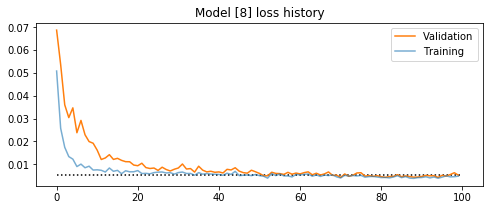

In [14]:
log, V, A, X = train_online(env, model, make_batch)
plot_history(log, 'Model [%d] loss history' % LATENT_DIM)

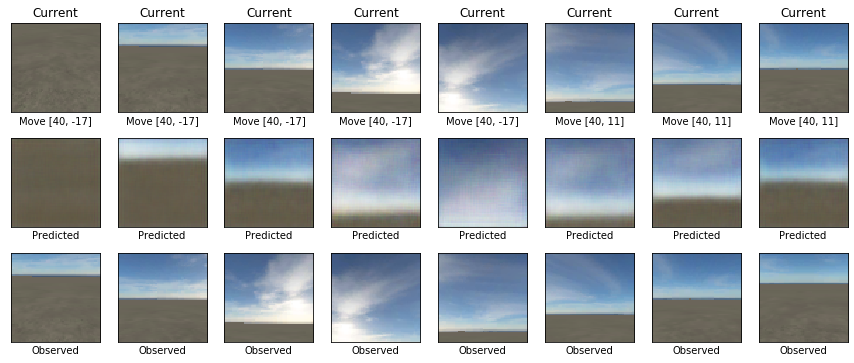

In [15]:
k = 9
env.reset()
_,__,___,____ = env.step([-180., 50.])
actions = [np.array([360./k, -150./k]) for i in range(k//2 + 1)] +\
          [np.array([360./k, 100./k]) for i in range(k//2)]
observations, coords = run_seq(env, actions, [-180., 50.])

actions = np.array(actions)[:-1,:]
views = np.array(observations)[:-1,:]
observations = np.array(observations)[1:,:]
predictions = model.predict([views, actions/360.])
plot_predicted_vs_observed(views, actions, predictions, observations)

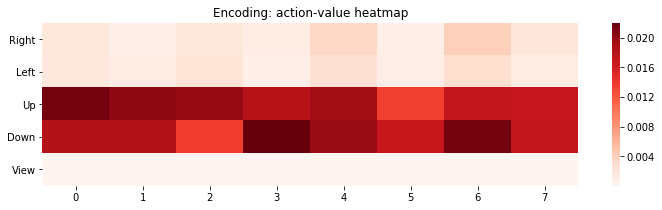

In [16]:
encoding_heatmap(env, encode, LATENT_DIM)    

No surprize here: most noticeable changes happen when moving up and down, left and right much less interesting, and view in general is quite obviously boring.

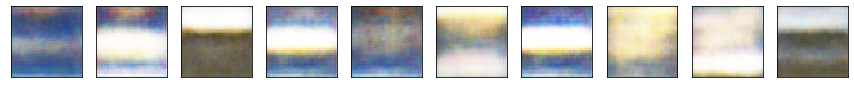

In [17]:
# decode random noise
def show_dreams(dreams):
    k = len(dreams)
    fig, ax = plt.subplots(1, k, figsize = (15, 6))
    for i in range(k):    
        ax[i].imshow(dreams[i,:])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()    

show_dreams(decode.predict(rnd.uniform(-1., 1., size = (10, LATENT_DIM))))


Training latent dim 4 ...
      1 Loss  trainig: 0.0527 validation: 0.0560
     10 Loss  trainig: 0.0095 validation: 0.0223
     20 Loss  trainig: 0.0081 validation: 0.0136
     30 Loss  trainig: 0.0068 validation: 0.0113
     40 Loss  trainig: 0.0068 validation: 0.0092
     50 Loss  trainig: 0.0066 validation: 0.0071
     60 Loss  trainig: 0.0058 validation: 0.0069
     70 Loss  trainig: 0.0058 validation: 0.0068
     80 Loss  trainig: 0.0063 validation: 0.0079
     90 Loss  trainig: 0.0063 validation: 0.0072
    100 Loss  trainig: 0.0052 validation: 0.0062


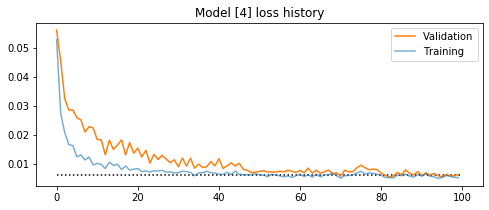

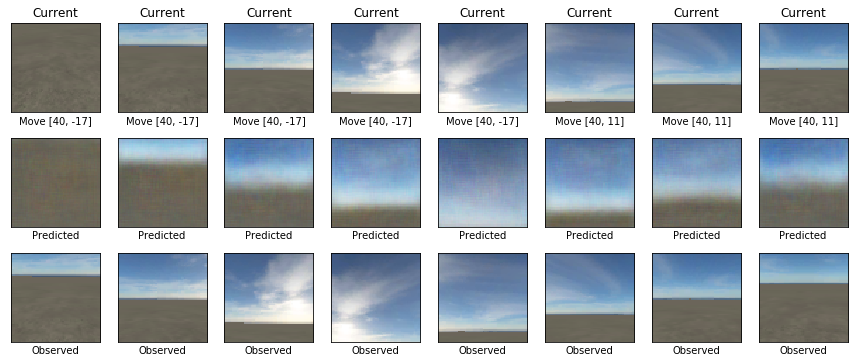

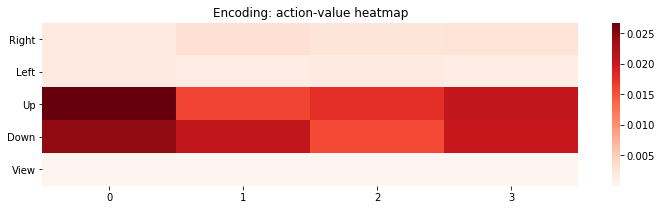

Dreams (decoded noise)


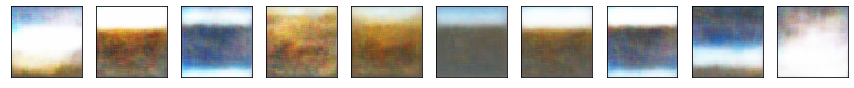


Training latent dim 16 ...
      1 Loss  trainig: 0.0466 validation: 0.0550
     10 Loss  trainig: 0.0064 validation: 0.0123
     20 Loss  trainig: 0.0055 validation: 0.0086
     30 Loss  trainig: 0.0043 validation: 0.0070
     40 Loss  trainig: 0.0040 validation: 0.0055
     50 Loss  trainig: 0.0045 validation: 0.0078
     60 Loss  trainig: 0.0038 validation: 0.0044
     70 Loss  trainig: 0.0034 validation: 0.0043
     80 Loss  trainig: 0.0030 validation: 0.0042
     90 Loss  trainig: 0.0026 validation: 0.0028
    100 Loss  trainig: 0.0023 validation: 0.0024


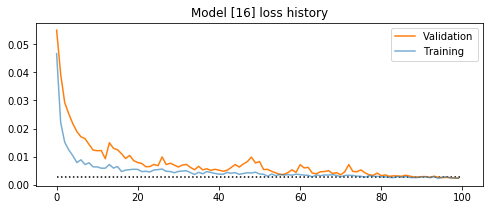

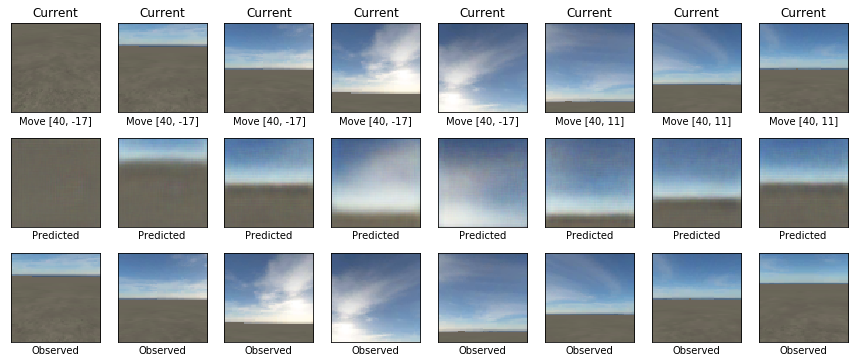

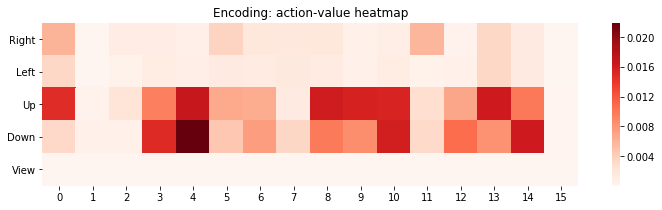

Dreams (decoded noise)


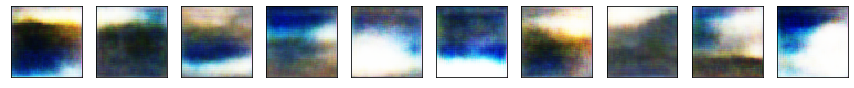


Training latent dim 32 ...
      1 Loss  trainig: 0.0496 validation: 0.1070
     10 Loss  trainig: 0.0062 validation: 0.0152
     20 Loss  trainig: 0.0053 validation: 0.0071
     30 Loss  trainig: 0.0043 validation: 0.0052
     40 Loss  trainig: 0.0045 validation: 0.0047
     50 Loss  trainig: 0.0040 validation: 0.0041
     60 Loss  trainig: 0.0040 validation: 0.0045
     70 Loss  trainig: 0.0028 validation: 0.0035
     80 Loss  trainig: 0.0031 validation: 0.0033
     90 Loss  trainig: 0.0024 validation: 0.0033
    100 Loss  trainig: 0.0021 validation: 0.0022


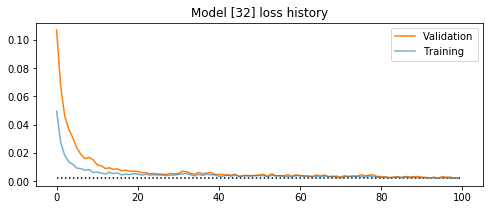

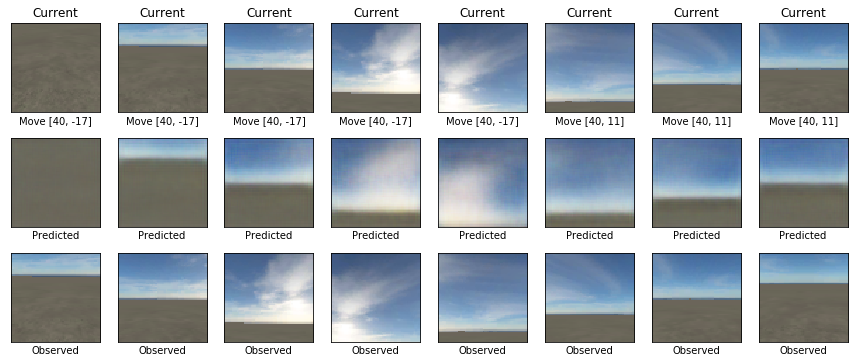

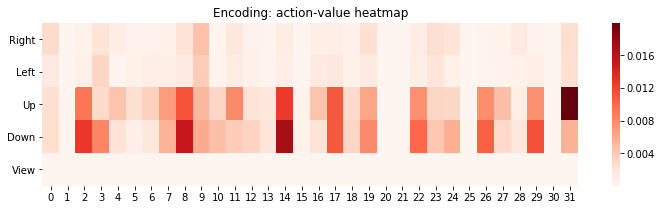

Dreams (decoded noise)


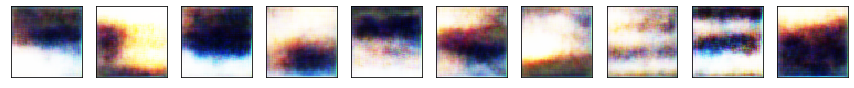

In [18]:
# check models with different latent dim
for dim in [4, 16, 32]:
    print('\nTraining latent dim {} ...'.format(dim))
    encode, decode, model = autoencoder(IMG_DIM, ACT_DIM, dim)
    log, V, A, X = train_online(env, model, make_batch)
    plot_history(log, 'Model [%d] loss history' % dim)
    predictions = model.predict([views, actions/360.])
    plot_predicted_vs_observed(views, actions, predictions, observations)
    encoding_heatmap(env, encode, dim)
    print('Dreams (decoded noise)')
    show_dreams(decode.predict(rnd.uniform(-1., 1., size = (10, dim))))

In [19]:
env.close()